# Convert to input for GCN

In [2]:
import pandas as pd

df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews-clean/clean_reviews.csv')

In [2]:
df.head()

,clean_reviews,sentiment
0,one reviewers mentioned watching 1 oz episode ...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically family little boy jake thinks zombie...,negative
4,mattei love time money visually stunning film ...,positive


In [3]:
list(df['clean_reviews'])[:2]

['one reviewers mentioned watching 1 oz episode hooked right exactly happened first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use word called oz nickname given oswald maximum security state focuses mainly emerald city experimental section prison cells glass fronts face privacy high agenda city home many aryans muslims latinos christians italians irish death stares dodgy dealings shady agreements never far away would say main appeal show due fact goes shows would dare forget pretty pictures painted mainstream audiences forget charm forget romance oz mess around first episode ever saw struck nasty surreal could say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards sold nickel inmates kill order get away well mannered middle class inmates turned prison bitches due lack street skills prison experience watchi

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['clean_reviews'], df['sentiment'], random_state=42, test_size=0.2, stratify=df['sentiment'])
X_test_ids = list(X_test.index)
X_test_ids[:5]

[18870, 39791, 30381, 42294, 33480]

## Prepare data

In [19]:
dataset_name = 'imdb'
sentences = list(df['clean_reviews'])
labels = list(df['sentiment'])
train_or_test_list = ['test' if idx in X_test_ids else 'train' for idx in df.index]

meta_data_list = []

for i in range(len(sentences)):
    meta = str(i) + '\t' + train_or_test_list[i] + '\t' + labels[i]
    meta_data_list.append(meta)

meta_data_str = '\n'.join(meta_data_list)

f = open(dataset_name + '.txt', 'w')
f.write(meta_data_str)
f.close()

corpus_str = '\n'.join(sentences)

f = open(dataset_name + '.corpus.txt', 'w')
f.write(corpus_str)
f.close()

## Utils

Jangan lupa ganti path ke dataset

In [1]:
import numpy as np
import pickle as pkl
import networkx as nx
import scipy.sparse as sp
from scipy.sparse.linalg.eigen.arpack import eigsh
import sys
import re


def parse_index_file(filename):
    """Parse index file."""
    index = []
    for line in open(filename):
        index.append(int(line.strip()))
    return index


def sample_mask(idx, l):
    """Create mask."""
    mask = np.zeros(l)
    mask[idx] = 1
    return np.array(mask, dtype=np.bool)


def load_data(dataset_str):
    """
    Loads input data from gcn/data directory
    ind.dataset_str.x => the feature vectors of the training instances as scipy.sparse.csr.csr_matrix object;
    ind.dataset_str.tx => the feature vectors of the test instances as scipy.sparse.csr.csr_matrix object;
    ind.dataset_str.allx => the feature vectors of both labeled and unlabeled training instances
        (a superset of ind.dataset_str.x) as scipy.sparse.csr.csr_matrix object;
    ind.dataset_str.y => the one-hot labels of the labeled training instances as numpy.ndarray object;
    ind.dataset_str.ty => the one-hot labels of the test instances as numpy.ndarray object;
    ind.dataset_str.ally => the labels for instances in ind.dataset_str.allx as numpy.ndarray object;
    ind.dataset_str.graph => a dict in the format {index: [index_of_neighbor_nodes]} as collections.defaultdict
        object;
    ind.dataset_str.test.index => the indices of test instances in graph, for the inductive setting as list object.
    All objects above must be saved using python pickle module.
    :param dataset_str: Dataset name
    :return: All data input files loaded (as well the training/test data).
    """
    names = ['x', 'y', 'tx', 'ty', 'allx', 'ally', 'adj']
    objects = []
    for i in range(len(names)):
        with open("/kaggle/input/imdb-dataset-of-50k-movie-reviews-clean/data/data/ind.{}.{}".format(dataset_str, names[i]), 'rb') as f:
            if sys.version_info > (3, 0):
                objects.append(pkl.load(f, encoding='latin1'))
            else:
                objects.append(pkl.load(f))

    x, y, tx, ty, allx, ally, graph = tuple(objects)
    test_idx_reorder = parse_index_file(
        "/kaggle/input/imdb-dataset-of-50k-movie-reviews-clean/data/data/{}.test.index".format(dataset_str))
    test_idx_range = np.sort(test_idx_reorder)
    print(x.shape, y.shape, tx.shape, ty.shape, allx.shape, ally.shape)

    # training nodes are training docs, no initial features
    # print("x: ", x)
    # test nodes are training docs, no initial features
    # print("tx: ", tx)
    # both labeled and unlabeled training instances are training docs and words
    # print("allx: ", allx)
    # training labels are training doc labels
    # print("y: ", y)
    # test labels are test doc labels
    # print("ty: ", ty)
    # ally are labels for labels for allx, some will not have labels, i.e., all 0
    # print("ally: \n")
    # for i in ally:
    # if(sum(i) == 0):
    # print(i)
    # graph edge weight is the word co-occurence or doc word frequency
    # no need to build map, directly build csr_matrix
    # print('graph : ', graph)

    if dataset_str == 'citeseer':
        # Fix citeseer dataset (there are some isolated nodes in the graph)
        # Find isolated nodes, add them as zero-vecs into the right position
        test_idx_range_full = range(
            min(test_idx_reorder), max(test_idx_reorder)+1)
        tx_extended = sp.lil_matrix((len(test_idx_range_full), x.shape[1]))
        tx_extended[test_idx_range-min(test_idx_range), :] = tx
        tx = tx_extended
        ty_extended = np.zeros((len(test_idx_range_full), y.shape[1]))
        ty_extended[test_idx_range-min(test_idx_range), :] = ty
        ty = ty_extended

    features = sp.vstack((allx, tx)).tolil()
    features[test_idx_reorder, :] = features[test_idx_range, :]
    adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))

    labels = np.vstack((ally, ty))
    labels[test_idx_reorder, :] = labels[test_idx_range, :]
    # print(len(labels))

    idx_test = test_idx_range.tolist()
    # print(idx_test)
    idx_train = range(len(y))
    idx_val = range(len(y), len(y)+500)

    train_mask = sample_mask(idx_train, labels.shape[0])
    val_mask = sample_mask(idx_val, labels.shape[0])
    test_mask = sample_mask(idx_test, labels.shape[0])

    y_train = np.zeros(labels.shape)
    y_val = np.zeros(labels.shape)
    y_test = np.zeros(labels.shape)
    y_train[train_mask, :] = labels[train_mask, :]
    y_val[val_mask, :] = labels[val_mask, :]
    y_test[test_mask, :] = labels[test_mask, :]

    return adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask


def load_corpus(dataset_str):
    """
    Loads input corpus from gcn/data directory
    ind.dataset_str.x => the feature vectors of the training docs as scipy.sparse.csr.csr_matrix object;
    ind.dataset_str.tx => the feature vectors of the test docs as scipy.sparse.csr.csr_matrix object;
    ind.dataset_str.allx => the feature vectors of both labeled and unlabeled training docs/words
        (a superset of ind.dataset_str.x) as scipy.sparse.csr.csr_matrix object;
    ind.dataset_str.y => the one-hot labels of the labeled training docs as numpy.ndarray object;
    ind.dataset_str.ty => the one-hot labels of the test docs as numpy.ndarray object;
    ind.dataset_str.ally => the labels for instances in ind.dataset_str.allx as numpy.ndarray object;
    ind.dataset_str.adj => adjacency matrix of word/doc nodes as scipy.sparse.csr.csr_matrix object;
    ind.dataset_str.train.index => the indices of training docs in original doc list.
    All objects above must be saved using python pickle module.
    :param dataset_str: Dataset name
    :return: All data input files loaded (as well the training/test data).
    """

    names = ['x', 'y', 'tx', 'ty', 'allx', 'ally', 'adj']
    objects = []
    for i in range(len(names)):
#         print(f"/kaggle/input/imdb-dataset-of-50k-movie-reviews-clean/data/data/ind.{dataset_str}.{names[i]}")
        
        with open("/kaggle/input/imdb-dataset-of-50k-movie-reviews-clean/data/data/ind.{}.{}".format(dataset_str, names[i]), 'rb') as f:
            if sys.version_info > (3, 0):
                objects.append(pkl.load(f, encoding='latin1'))
            else:
                objects.append(pkl.load(f))

    x, y, tx, ty, allx, ally, adj = tuple(objects)
    print(x.shape, y.shape, tx.shape, ty.shape, allx.shape, ally.shape)

    features = sp.vstack((allx, tx)).tolil()
    labels = np.vstack((ally, ty))
    print(len(labels))

    train_idx_orig = parse_index_file(
        "/kaggle/input/imdb-dataset-of-50k-movie-reviews-clean/data/data/{}.train.index".format(dataset_str))
    train_size = len(train_idx_orig)

    val_size = train_size - x.shape[0]
    test_size = tx.shape[0]

    idx_train = range(len(y))
    idx_val = range(len(y), len(y) + val_size)
    idx_test = range(allx.shape[0], allx.shape[0] + test_size)

    train_mask = sample_mask(idx_train, labels.shape[0])
    val_mask = sample_mask(idx_val, labels.shape[0])
    test_mask = sample_mask(idx_test, labels.shape[0])

    y_train = np.zeros(labels.shape)
    y_val = np.zeros(labels.shape)
    y_test = np.zeros(labels.shape)
    y_train[train_mask, :] = labels[train_mask, :]
    y_val[val_mask, :] = labels[val_mask, :]
    y_test[test_mask, :] = labels[test_mask, :]

    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    return adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, train_size, test_size


def sparse_to_tuple(sparse_mx):
    """Convert sparse matrix to tuple representation."""
    def to_tuple(mx):
        if not sp.isspmatrix_coo(mx):
            mx = mx.tocoo()
        coords = np.vstack((mx.row, mx.col)).transpose()
        values = mx.data
        shape = mx.shape
        return coords, values, shape

    if isinstance(sparse_mx, list):
        for i in range(len(sparse_mx)):
            sparse_mx[i] = to_tuple(sparse_mx[i])
    else:
        sparse_mx = to_tuple(sparse_mx)

    return sparse_mx


def preprocess_features(features):
    """Row-normalize feature matrix and convert to tuple representation"""
    rowsum = np.array(features.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    features = r_mat_inv.dot(features)
    return sparse_to_tuple(features)


def normalize_adj(adj):
    """Symmetrically normalize adjacency matrix."""
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()


def preprocess_adj(adj):
    """Preprocessing of adjacency matrix for simple GCN model and conversion to tuple representation."""
    adj_normalized = normalize_adj(adj + sp.eye(adj.shape[0]))
    return sparse_to_tuple(adj_normalized)


def construct_feed_dict(features, support, labels, labels_mask, placeholders):
    """Construct feed dictionary."""
    feed_dict = dict()
    feed_dict.update({placeholders['labels']: labels})
    feed_dict.update({placeholders['labels_mask']: labels_mask})
    feed_dict.update({placeholders['features']: features})
    feed_dict.update({placeholders['support'][i]: support[i]
                      for i in range(len(support))})
    feed_dict.update({placeholders['num_features_nonzero']: features[1].shape})
    return feed_dict


def chebyshev_polynomials(adj, k):
    """Calculate Chebyshev polynomials up to order k. Return a list of sparse matrices (tuple representation)."""
    print("Calculating Chebyshev polynomials up to order {}...".format(k))

    adj_normalized = normalize_adj(adj)
    laplacian = sp.eye(adj.shape[0]) - adj_normalized
    largest_eigval, _ = eigsh(laplacian, 1, which='LM')
    scaled_laplacian = (
        2. / largest_eigval[0]) * laplacian - sp.eye(adj.shape[0])

    t_k = list()
    t_k.append(sp.eye(adj.shape[0]))
    t_k.append(scaled_laplacian)

    def chebyshev_recurrence(t_k_minus_one, t_k_minus_two, scaled_lap):
        s_lap = sp.csr_matrix(scaled_lap, copy=True)
        return 2 * s_lap.dot(t_k_minus_one) - t_k_minus_two

    for i in range(2, k+1):
        t_k.append(chebyshev_recurrence(t_k[-1], t_k[-2], scaled_laplacian))

    return sparse_to_tuple(t_k)


def loadWord2Vec(filename):
    """Read Word Vectors"""
    vocab = []
    embd = []
    word_vector_map = {}
    file = open(filename, 'r')
    for line in file.readlines():
        row = line.strip().split(' ')
        if(len(row) > 2):
            vocab.append(row[0])
            vector = row[1:]
            length = len(vector)
            for i in range(length):
                vector[i] = float(vector[i])
            embd.append(vector)
            word_vector_map[row[0]] = vector
    print('Loaded Word Vectors!')
    file.close()
    return vocab, embd, word_vector_map

def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

## Remove words

In [23]:
from nltk.corpus import stopwords
import nltk
from nltk.wsd import lesk
from nltk.corpus import wordnet as wn
import sys

dataset = 'imdb'

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
print(stop_words)

# Read Word Vectors
# word_vector_file = 'data/glove.6B/glove.6B.200d.txt'
# vocab, embd, word_vector_map = loadWord2Vec(word_vector_file)
# word_embeddings_dim = len(embd[0])
# dataset = '20ng'

doc_content_list = []
f = open(dataset + '.corpus.txt', 'rb')
# f = open('data/wiki_long_abstracts_en_text.txt', 'r')
for line in f.readlines():
    doc_content_list.append(line.strip().decode('latin1'))
f.close()


word_freq = {}  # to remove rare words

for doc_content in doc_content_list:
    temp = clean_str(doc_content)
    words = temp.split()
    for word in words:
        if word in word_freq:
            word_freq[word] += 1
        else:
            word_freq[word] = 1

clean_docs = []
for doc_content in doc_content_list:
    temp = clean_str(doc_content)
    words = temp.split()
    doc_words = []
    for word in words:
        # word not in stop_words and word_freq[word] >= 5
        if dataset == 'mr':
            doc_words.append(word)
        elif word not in stop_words and word_freq[word] >= 5:
            doc_words.append(word)

    doc_str = ' '.join(doc_words).strip()
    #if doc_str == '':
        #doc_str = temp
    clean_docs.append(doc_str)

clean_corpus_str = '\n'.join(clean_docs)

f = open(dataset + '.corpus.clean.txt', 'w')
#f = open('data/wiki_long_abstracts_en_text.clean.txt', 'w')
f.write(clean_corpus_str)
f.close()

#dataset = '20ng'
min_len = 10000
aver_len = 0
max_len = 0 

f = open(dataset + '.corpus.clean.txt', 'r')
#f = open('data/wiki_long_abstracts_en_text.txt', 'r')
lines = f.readlines()
for line in lines:
    line = line.strip()
    temp = line.split()
    aver_len = aver_len + len(temp)
    if len(temp) < min_len:
        min_len = len(temp)
    if len(temp) > max_len:
        max_len = len(temp)
f.close()
aver_len = 1.0 * aver_len / len(lines)
print('min_len : ' + str(min_len))
print('max_len : ' + str(max_len))
print('average_len : ' + str(aver_len))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'shouldn', 'shan', 'his', 'being', 'on', 'their', 'so', 'who', 'those', 'no', 'the', 'isn', 'above', 'weren', "hadn't", 'over', 'because', 'which', "didn't", 'yourself', 'needn', 'most', 'any', "needn't", 'doing', 'i', 'through', "mustn't", 'them', 'before', 'each', 'are', 'wasn', "hasn't", 'will', 'and', 'mustn', 'only', 'yourselves', 'does', 'own', 'now', 'just', 'if', 't', 'yours', 'me', 'at', 'not', 'a', 'both', 'aren', "aren't", 'was', 'ma', 'few', 'out', 'am', 'ain', 've', "doesn't", 'couldn', 'again', "mightn't", "shan't", 'my', 'here', 'as', 'should', 'there', "wouldn't", 'too', 'between', "that'll", 'all', 'that', "shouldn't", 'into', 'whom', 'this', 'against', 'why', 'herself', 'didn', 'haven', 'of', 'than', 'other', 'is', 'off', 'an', 'below', "it's", "you'll", "won't", 'for', 'him', 'it', 'll', 'hers', 'by', 'but', 'once', 'some', 'your', 'can', 'our', 'won', 'y', 'or', 'have', 'did', 'he', 'in', 'don', 'hadn', "you're", 'themselves', 'such', 'had', "isn't", 'itself', 'her

## Build Graph

In [ ]:
import os
import random
import numpy as np
import pickle as pkl
import networkx as nx
import scipy.sparse as sp
from math import log
from sklearn import svm
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
import sys
from scipy.spatial.distance import cosine
nltk.download(['omw-1.4', 'wordnet'])

# build corpus
dataset = 'imdb'

# Read Word Vectors
# word_vector_file = 'data/glove.6B/glove.6B.300d.txt'
# word_vector_file = 'data/corpus/' + dataset + '_word_vectors.txt'
#_, embd, word_vector_map = loadWord2Vec(word_vector_file)
# word_embeddings_dim = len(embd[0])

word_embeddings_dim = 300
word_vector_map = {}

# shulffing
doc_name_list = []
doc_train_list = []
doc_test_list = []

f = open(dataset + '.txt', 'r')
lines = f.readlines()
for line in lines:
    doc_name_list.append(line.strip())
    temp = line.split("\t")
    if temp[1].find('test') != -1:
        doc_test_list.append(line.strip())
    elif temp[1].find('train') != -1:
        doc_train_list.append(line.strip())
f.close()
# print(doc_train_list)
# print(doc_test_list)

doc_content_list = []
f = open(dataset + '.corpus.clean.txt', 'r')
lines = f.readlines()
for line in lines:
    doc_content_list.append(line.strip())
f.close()
# print(doc_content_list)

train_ids = []
for train_name in doc_train_list:
    train_id = doc_name_list.index(train_name)
    train_ids.append(train_id)
print(train_ids[:5])
random.shuffle(train_ids)

# partial labeled data
#train_ids = train_ids[:int(0.2 * len(train_ids))]

train_ids_str = '\n'.join(str(index) for index in train_ids)
f = open(dataset + '.train.index', 'w')
f.write(train_ids_str)
f.close()

test_ids = []
for test_name in doc_test_list:
    test_id = doc_name_list.index(test_name)
    test_ids.append(test_id)
print(test_ids[:5])
random.shuffle(test_ids)

test_ids_str = '\n'.join(str(index) for index in test_ids)
f = open(dataset + '.test.index', 'w')
f.write(test_ids_str)
f.close()

ids = train_ids + test_ids
print(len(ids))

shuffle_doc_name_list = []
shuffle_doc_words_list = []
for id in ids:
    shuffle_doc_name_list.append(doc_name_list[int(id)])
    shuffle_doc_words_list.append(doc_content_list[int(id)])
shuffle_doc_name_str = '\n'.join(shuffle_doc_name_list)
shuffle_doc_words_str = '\n'.join(shuffle_doc_words_list)

f = open(dataset + '_shuffle.txt', 'w')
f.write(shuffle_doc_name_str)
f.close()

f = open(dataset + '_shuffle.corpus.txt', 'w')
f.write(shuffle_doc_words_str)
f.close()

# build vocab
word_freq = {}
word_set = set()
for doc_words in shuffle_doc_words_list:
    words = doc_words.split()
    for word in words:
        word_set.add(word)
        if word in word_freq:
            word_freq[word] += 1
        else:
            word_freq[word] = 1

vocab = list(word_set)
vocab_size = len(vocab)

word_doc_list = {}

for i in range(len(shuffle_doc_words_list)):
    doc_words = shuffle_doc_words_list[i]
    words = doc_words.split()
    appeared = set()
    for word in words:
        if word in appeared:
            continue
        if word in word_doc_list:
            doc_list = word_doc_list[word]
            doc_list.append(i)
            word_doc_list[word] = doc_list
        else:
            word_doc_list[word] = [i]
        appeared.add(word)

word_doc_freq = {}
for word, doc_list in word_doc_list.items():
    word_doc_freq[word] = len(doc_list)

word_id_map = {}
for i in range(vocab_size):
    word_id_map[vocab[i]] = i

vocab_str = '\n'.join(vocab)

f = open(dataset + '_vocab.corpus.txt', 'w')
f.write(vocab_str)
f.close()

'''
Word definitions begin
'''
definitions = []
for word in vocab:
    word = word.strip()
    synsets = wn.synsets(clean_str(word))
    word_defs = []
    for synset in synsets:
        syn_def = synset.definition()
        word_defs.append(syn_def)
    word_des = ' '.join(word_defs)
    if word_des == '':
        word_des = '<PAD>'
    definitions.append(word_des)
string = '\n'.join(definitions)
f = open(dataset + '_vocab_def.corpus.txt', 'w')
f.write(string)
f.close()
tfidf_vec = TfidfVectorizer(max_features=1000)
tfidf_matrix = tfidf_vec.fit_transform(definitions)
tfidf_matrix_array = tfidf_matrix.toarray()
print(tfidf_matrix_array[0], len(tfidf_matrix_array[0]))
word_vectors = []
for i in range(len(vocab)):
    word = vocab[i]
    vector = tfidf_matrix_array[i]
    str_vector = []
    for j in range(len(vector)):
        str_vector.append(str(vector[j]))
    temp = ' '.join(str_vector)
    word_vector = word + ' ' + temp
    word_vectors.append(word_vector)
string = '\n'.join(word_vectors)
f = open(dataset + '_word_vectors.corpus.txt', 'w')
f.write(string)
f.close()
word_vector_file = dataset + '_word_vectors.corpus.txt'
_, embd, word_vector_map = loadWord2Vec(word_vector_file)
word_embeddings_dim = len(embd[0])

'''
Word definitions end
'''

# label list
label_set = set()
for doc_meta in shuffle_doc_name_list:
    temp = doc_meta.split('\t')
    label_set.add(temp[2])
label_list = list(label_set)

label_list_str = '\n'.join(label_list)
f = open(dataset + '_labels.corpus.txt', 'w')
f.write(label_list_str)
f.close()

# x: feature vectors of training docs, no initial features
# slect 90% training set
train_size = len(train_ids)
val_size = int(0.1 * train_size)
real_train_size = train_size - val_size  # - int(0.5 * train_size)
# different training rates

real_train_doc_names = shuffle_doc_name_list[:real_train_size]
real_train_doc_names_str = '\n'.join(real_train_doc_names)

f = open(dataset + '.real_train.name', 'w')
f.write(real_train_doc_names_str)
f.close()

row_x = []
col_x = []
data_x = []
for i in range(real_train_size):
    doc_vec = np.array([0.0 for k in range(word_embeddings_dim)])
    doc_words = shuffle_doc_words_list[i]
    words = doc_words.split()
    doc_len = len(words)
    for word in words:
        if word in word_vector_map:
            word_vector = word_vector_map[word]
            # print(doc_vec)
            # print(np.array(word_vector))
            doc_vec = doc_vec + np.array(word_vector)

    for j in range(word_embeddings_dim):
        row_x.append(i)
        col_x.append(j)
        # np.random.uniform(-0.25, 0.25)
        data_x.append(doc_vec[j] / doc_len)  # doc_vec[j]/ doc_len

# x = sp.csr_matrix((real_train_size, word_embeddings_dim), dtype=np.float32)
x = sp.csr_matrix((data_x, (row_x, col_x)), shape=(
    real_train_size, word_embeddings_dim))

y = []
for i in range(real_train_size):
    doc_meta = shuffle_doc_name_list[i]
    temp = doc_meta.split('\t')
    label = temp[2]
    one_hot = [0 for l in range(len(label_list))]
    label_index = label_list.index(label)
    one_hot[label_index] = 1
    y.append(one_hot)
y = np.array(y)

# tx: feature vectors of test docs, no initial features
test_size = len(test_ids)

row_tx = []
col_tx = []
data_tx = []
for i in range(test_size):
    doc_vec = np.array([0.0 for k in range(word_embeddings_dim)])
    doc_words = shuffle_doc_words_list[i + train_size]
    words = doc_words.split()
    doc_len = len(words)
    for word in words:
        if word in word_vector_map:
            word_vector = word_vector_map[word]
            doc_vec = doc_vec + np.array(word_vector)

    for j in range(word_embeddings_dim):
        row_tx.append(i)
        col_tx.append(j)
        # np.random.uniform(-0.25, 0.25)
        data_tx.append(doc_vec[j] / doc_len)  # doc_vec[j] / doc_len

# tx = sp.csr_matrix((test_size, word_embeddings_dim), dtype=np.float32)
tx = sp.csr_matrix((data_tx, (row_tx, col_tx)),
                   shape=(test_size, word_embeddings_dim))

ty = []
for i in range(test_size):
    doc_meta = shuffle_doc_name_list[i + train_size]
    temp = doc_meta.split('\t')
    label = temp[2]
    one_hot = [0 for l in range(len(label_list))]
    label_index = label_list.index(label)
    one_hot[label_index] = 1
    ty.append(one_hot)
ty = np.array(ty)

# allx: the the feature vectors of both labeled and unlabeled training instances
# (a superset of x)
# unlabeled training instances -> words

word_vectors = np.random.uniform(-0.01, 0.01,
                                 (vocab_size, word_embeddings_dim))

for i in range(len(vocab)):
    word = vocab[i]
    if word in word_vector_map:
        vector = word_vector_map[word]
        word_vectors[i] = vector

row_allx = []
col_allx = []
data_allx = []

for i in range(train_size):
    doc_vec = np.array([0.0 for k in range(word_embeddings_dim)])
    doc_words = shuffle_doc_words_list[i]
    words = doc_words.split()
    doc_len = len(words)
    for word in words:
        if word in word_vector_map:
            word_vector = word_vector_map[word]
            doc_vec = doc_vec + np.array(word_vector)

    for j in range(word_embeddings_dim):
        row_allx.append(int(i))
        col_allx.append(j)
        # np.random.uniform(-0.25, 0.25)
        data_allx.append(doc_vec[j] / doc_len)  # doc_vec[j]/doc_len
for i in range(vocab_size):
    for j in range(word_embeddings_dim):
        row_allx.append(int(i + train_size))
        col_allx.append(j)
        data_allx.append(word_vectors.item((i, j)))


row_allx = np.array(row_allx)
col_allx = np.array(col_allx)
data_allx = np.array(data_allx)

allx = sp.csr_matrix(
    (data_allx, (row_allx, col_allx)), shape=(train_size + vocab_size, word_embeddings_dim))

ally = []
for i in range(train_size):
    doc_meta = shuffle_doc_name_list[i]
    temp = doc_meta.split('\t')
    label = temp[2]
    one_hot = [0 for l in range(len(label_list))]
    label_index = label_list.index(label)
    one_hot[label_index] = 1
    ally.append(one_hot)

for i in range(vocab_size):
    one_hot = [0 for l in range(len(label_list))]
    ally.append(one_hot)

ally = np.array(ally)

print(x.shape, y.shape, tx.shape, ty.shape, allx.shape, ally.shape)

'''
Doc word heterogeneous graph
'''

# word co-occurence with context windows
window_size = 20
windows = []

for doc_words in shuffle_doc_words_list:
    words = doc_words.split()
    length = len(words)
    if length <= window_size:
        windows.append(words)
    else:
        # print(length, length - window_size + 1)
        for j in range(length - window_size + 1):
            window = words[j: j + window_size]
            windows.append(window)
            # print(window)


word_window_freq = {}
for window in windows:
    appeared = set()
    for i in range(len(window)):
        if window[i] in appeared:
            continue
        if window[i] in word_window_freq:
            word_window_freq[window[i]] += 1
        else:
            word_window_freq[window[i]] = 1
        appeared.add(window[i])

word_pair_count = {}
for window in windows:
    for i in range(1, len(window)):
        for j in range(0, i):
            word_i = window[i]
            word_i_id = word_id_map[word_i]
            word_j = window[j]
            word_j_id = word_id_map[word_j]
            if word_i_id == word_j_id:
                continue
            word_pair_str = str(word_i_id) + ',' + str(word_j_id)
            if word_pair_str in word_pair_count:
                word_pair_count[word_pair_str] += 1
            else:
                word_pair_count[word_pair_str] = 1
            # two orders
            word_pair_str = str(word_j_id) + ',' + str(word_i_id)
            if word_pair_str in word_pair_count:
                word_pair_count[word_pair_str] += 1
            else:
                word_pair_count[word_pair_str] = 1

row = []
col = []
weight = []

# pmi as weights

num_window = len(windows)

for key in word_pair_count:
    temp = key.split(',')
    i = int(temp[0])
    j = int(temp[1])
    count = word_pair_count[key]
    word_freq_i = word_window_freq[vocab[i]]
    word_freq_j = word_window_freq[vocab[j]]
    pmi = log((1.0 * count / num_window) /
              (1.0 * word_freq_i * word_freq_j/(num_window * num_window)))
    if pmi <= 0:
        continue
    row.append(train_size + i)
    col.append(train_size + j)
    weight.append(pmi)

# word vector cosine similarity as weights

'''
for i in range(vocab_size):
    for j in range(vocab_size):
        if vocab[i] in word_vector_map and vocab[j] in word_vector_map:
            vector_i = np.array(word_vector_map[vocab[i]])
            vector_j = np.array(word_vector_map[vocab[j]])
            similarity = 1.0 - cosine(vector_i, vector_j)
            if similarity > 0.9:
                print(vocab[i], vocab[j], similarity)
                row.append(train_size + i)
                col.append(train_size + j)
                weight.append(similarity)
'''
# doc word frequency
doc_word_freq = {}

for doc_id in range(len(shuffle_doc_words_list)):
    doc_words = shuffle_doc_words_list[doc_id]
    words = doc_words.split()
    for word in words:
        word_id = word_id_map[word]
        doc_word_str = str(doc_id) + ',' + str(word_id)
        if doc_word_str in doc_word_freq:
            doc_word_freq[doc_word_str] += 1
        else:
            doc_word_freq[doc_word_str] = 1

for i in range(len(shuffle_doc_words_list)):
    doc_words = shuffle_doc_words_list[i]
    words = doc_words.split()
    doc_word_set = set()
    for word in words:
        if word in doc_word_set:
            continue
        j = word_id_map[word]
        key = str(i) + ',' + str(j)
        freq = doc_word_freq[key]
        if i < train_size:
            row.append(i)
        else:
            row.append(i + vocab_size)
        col.append(train_size + j)
        idf = log(1.0 * len(shuffle_doc_words_list) /
                  word_doc_freq[vocab[j]])
        weight.append(freq * idf)
        doc_word_set.add(word)

node_size = train_size + vocab_size + test_size
adj = sp.csr_matrix(
    (weight, (row, col)), shape=(node_size, node_size))

# dump objects
f = open("ind.{}.x".format(dataset), 'wb')
pkl.dump(x, f)
f.close()

f = open("ind.{}.y".format(dataset), 'wb')
pkl.dump(y, f)
f.close()

f = open("ind.{}.tx".format(dataset), 'wb')
pkl.dump(tx, f)
f.close()

f = open("ind.{}.ty".format(dataset), 'wb')
pkl.dump(ty, f)
f.close()

f = open("ind.{}.allx".format(dataset), 'wb')
pkl.dump(allx, f)
f.close()

f = open("ind.{}.ally".format(dataset), 'wb')
pkl.dump(ally, f)
f.close()

f = open("ind.{}.adj".format(dataset), 'wb')
pkl.dump(adj, f)
f.close()

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[0, 1, 3, 5, 6]
[2, 4, 16, 19, 23]
50000
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.40734651
 0.         0.         0.         0.         0.         0.
 0.         0.         0.40288035 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.    

## Inits

In [2]:
import tensorflow.compat.v1 as tf
import numpy as np


def uniform(shape, scale=0.05, name=None):
    """Uniform init."""
    initial = tf.random_uniform(shape, minval=-scale, maxval=scale, dtype=tf.float32)
    return tf.Variable(initial, name=name)


def glorot(shape, name=None):
    """Glorot & Bengio (AISTATS 2010) init."""
    init_range = np.sqrt(6.0/(shape[0]+shape[1]))
    initial = tf.random_uniform(shape, minval=-init_range, maxval=init_range, dtype=tf.float32)
    return tf.Variable(initial, name=name)


def zeros(shape, name=None):
    """All zeros."""
    initial = tf.zeros(shape, dtype=tf.float32)
    return tf.Variable(initial, name=name)


def ones(shape, name=None):
    """All ones."""
    initial = tf.ones(shape, dtype=tf.float32)
    return tf.Variable(initial, name=name)

## Metrics

In [4]:
def masked_softmax_cross_entropy(preds, labels, mask):
    """Softmax cross-entropy loss with masking."""
    print(preds)
    loss = tf.nn.softmax_cross_entropy_with_logits(logits=preds, labels=labels)
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    loss *= mask
    return tf.reduce_mean(loss)


def masked_accuracy(preds, labels, mask):
    """Accuracy with masking."""
    correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(labels, 1))

    accuracy_all = tf.cast(correct_prediction, tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    accuracy_all *= mask
    return tf.reduce_mean(accuracy_all)

## Layers

In [5]:
flags = tf.app.flags
FLAGS = flags.FLAGS

# global unique layer ID dictionary for layer name assignment
_LAYER_UIDS = {}


def get_layer_uid(layer_name=''):
    """Helper function, assigns unique layer IDs."""
    if layer_name not in _LAYER_UIDS:
        _LAYER_UIDS[layer_name] = 1
        return 1
    else:
        _LAYER_UIDS[layer_name] += 1
        return _LAYER_UIDS[layer_name]


def sparse_dropout(x, keep_prob, noise_shape):
    """Dropout for sparse tensors."""
    random_tensor = keep_prob
    random_tensor += tf.random_uniform(noise_shape)
    dropout_mask = tf.cast(tf.floor(random_tensor), dtype=tf.bool)
    pre_out = tf.sparse_retain(x, dropout_mask)
    return pre_out * (1./keep_prob)


def dot(x, y, sparse=False):
    """Wrapper for tf.matmul (sparse vs dense)."""
    if sparse:
        res = tf.sparse_tensor_dense_matmul(x, y)
    else:
        res = tf.matmul(x, y)
    return res


class Layer(object):
    """Base layer class. Defines basic API for all layer objects.
    Implementation inspired by keras (http://keras.io).
    # Properties
        name: String, defines the variable scope of the layer.
        logging: Boolean, switches Tensorflow histogram logging on/off
    # Methods
        _call(inputs): Defines computation graph of layer
            (i.e. takes input, returns output)
        __call__(inputs): Wrapper for _call()
        _log_vars(): Log all variables
    """

    def __init__(self, **kwargs):
        allowed_kwargs = {'name', 'logging'}
        for kwarg in kwargs.keys():
            assert kwarg in allowed_kwargs, 'Invalid keyword argument: ' + kwarg
        name = kwargs.get('name')
        if not name:
            layer = self.__class__.__name__.lower()
            name = layer + '_' + str(get_layer_uid(layer))
        self.name = name
        self.vars = {}
        logging = kwargs.get('logging', False)
        self.logging = logging
        self.sparse_inputs = False

    def _call(self, inputs):
        return inputs

    def __call__(self, inputs):
        with tf.name_scope(self.name):
            if self.logging and not self.sparse_inputs:
                tf.summary.histogram(self.name + '/inputs', inputs)
            outputs = self._call(inputs)
            if self.logging:
                tf.summary.histogram(self.name + '/outputs', outputs)
            return outputs

    def _log_vars(self):
        for var in self.vars:
            tf.summary.histogram(self.name + '/vars/' + var, self.vars[var])


class Dense(Layer):
    """Dense layer."""
    def __init__(self, input_dim, output_dim, placeholders, dropout=0., sparse_inputs=False,
                 act=tf.nn.relu, bias=False, featureless=False, **kwargs):
        super(Dense, self).__init__(**kwargs)

        if dropout:
            self.dropout = placeholders['dropout']
        else:
            self.dropout = 0.

        self.act = act
        self.sparse_inputs = sparse_inputs
        self.featureless = featureless
        self.bias = bias

        # helper variable for sparse dropout
        self.num_features_nonzero = placeholders['num_features_nonzero']

        with tf.variable_scope(self.name + '_vars'):
            self.vars['weights'] = glorot([input_dim, output_dim],
                                          name='weights')
            if self.bias:
                self.vars['bias'] = zeros([output_dim], name='bias')

        if self.logging:
            self._log_vars()

    def _call(self, inputs):
        x = inputs

        # dropout
        if self.sparse_inputs:
            x = sparse_dropout(x, 1-self.dropout, self.num_features_nonzero)
        else:
            x = tf.nn.dropout(x, 1-self.dropout)

        # transform
        output = dot(x, self.vars['weights'], sparse=self.sparse_inputs)

        # bias
        if self.bias:
            output += self.vars['bias']

        return self.act(output)


class GraphConvolution(Layer):
    """Graph convolution layer."""
    def __init__(self, input_dim, output_dim, placeholders, dropout=0.,
                 sparse_inputs=False, act=tf.nn.relu, bias=False,
                 featureless=False, **kwargs):
        super(GraphConvolution, self).__init__(**kwargs)

        if dropout:
            self.dropout = placeholders['dropout']
        else:
            self.dropout = 0.

        self.act = act
        self.support = placeholders['support']
        self.sparse_inputs = sparse_inputs
        self.featureless = featureless
        self.bias = bias

        # helper variable for sparse dropout
        self.num_features_nonzero = placeholders['num_features_nonzero']

        with tf.variable_scope(self.name + '_vars'):
            for i in range(len(self.support)):
                self.vars['weights_' + str(i)] = glorot([input_dim, output_dim],
                                                        name='weights_' + str(i))
            if self.bias:
                self.vars['bias'] = zeros([output_dim], name='bias')

        if self.logging:
            self._log_vars()

    def _call(self, inputs):
        x = inputs

        # dropout
        if self.sparse_inputs:
            x = sparse_dropout(x, 1-self.dropout, self.num_features_nonzero)
        else:
            x = tf.nn.dropout(x, 1-self.dropout)

        # convolve
        supports = list()
        for i in range(len(self.support)):
            if not self.featureless:
                pre_sup = dot(x, self.vars['weights_' + str(i)],
                              sparse=self.sparse_inputs)
            else:
                pre_sup = self.vars['weights_' + str(i)]
            support = dot(self.support[i], pre_sup, sparse=True)
            supports.append(support)
        output = tf.add_n(supports)

        # bias
        if self.bias:
            output += self.vars['bias']
        self.embedding = output #output
        return self.act(output)

## Models

In [8]:
flags = tf.app.flags
FLAGS = flags.FLAGS


class Model(object):
    def __init__(self, **kwargs):
        allowed_kwargs = {'name', 'logging'}
        for kwarg in kwargs.keys():
            assert kwarg in allowed_kwargs, 'Invalid keyword argument: ' + kwarg
        name = kwargs.get('name')
        if not name:
            name = self.__class__.__name__.lower()
        self.name = name

        logging = kwargs.get('logging', False)
        self.logging = logging

        self.vars = {}
        self.placeholders = {}

        self.layers = []
        self.activations = []

        self.inputs = None
        self.outputs = None

        self.loss = 0
        self.accuracy = 0
        self.optimizer = None
        self.opt_op = None

    def _build(self):
        raise NotImplementedError

    def build(self):
        """ Wrapper for _build() """
        with tf.variable_scope(self.name):
            self._build()

        # Build sequential layer model
        self.activations.append(self.inputs)
        for layer in self.layers:
            hidden = layer(self.activations[-1])
            self.activations.append(hidden)
        self.outputs = self.activations[-1]

        # Store model variables for easy access
        variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=self.name)
        self.vars = {var.name: var for var in variables}

        # Build metrics
        self._loss()
        self._accuracy()

        self.opt_op = self.optimizer.minimize(self.loss)

    def predict(self):
        pass

    def _loss(self):
        raise NotImplementedError

    def _accuracy(self):
        raise NotImplementedError

    def save(self, sess=None):
        if not sess:
            raise AttributeError("TensorFlow session not provided.")
        saver = tf.train.Saver(self.vars)
        save_path = saver.save(sess, "tmp/%s.ckpt" % self.name)
        print("Model saved in file: %s" % save_path)

    def load(self, sess=None):
        if not sess:
            raise AttributeError("TensorFlow session not provided.")
        saver = tf.train.Saver(self.vars)
        save_path = "tmp/%s.ckpt" % self.name
        saver.restore(sess, save_path)
        print("Model restored from file: %s" % save_path)


class MLP(Model):
    def __init__(self, placeholders, input_dim, **kwargs):
        super(MLP, self).__init__(**kwargs)

        self.inputs = placeholders['features']
        self.input_dim = input_dim
        # self.input_dim = self.inputs.get_shape().as_list()[1]  # To be supported in future Tensorflow versions
        self.output_dim = placeholders['labels'].get_shape().as_list()[1]
        self.placeholders = placeholders

        self.optimizer = tf.train.AdamOptimizer(learning_rate=FLAGS.learning_rate)

        self.build()

    def _loss(self):
        # Weight decay loss
        for var in self.layers[0].vars.values():
            self.loss += FLAGS.weight_decay * tf.nn.l2_loss(var)

        # Cross entropy error
        self.loss += masked_softmax_cross_entropy(self.outputs, self.placeholders['labels'],
                                                  self.placeholders['labels_mask'])

    def _accuracy(self):
        self.accuracy = masked_accuracy(self.outputs, self.placeholders['labels'],
                                        self.placeholders['labels_mask'])

    def _build(self):
        self.layers.append(Dense(input_dim=self.input_dim,
                                 output_dim=FLAGS.hidden1,
                                 placeholders=self.placeholders,
                                 act=tf.nn.relu,
                                 dropout=True,
                                 sparse_inputs=True,
                                 logging=self.logging))

        self.layers.append(Dense(input_dim=FLAGS.hidden1,
                                 output_dim=self.output_dim,
                                 placeholders=self.placeholders,
                                 act=lambda x: x,
                                 dropout=True,
                                 logging=self.logging))

    def predict(self):
        return tf.nn.softmax(self.outputs)


class GCN(Model):
    def __init__(self, placeholders, input_dim, **kwargs):
        super(GCN, self).__init__(**kwargs)

        self.inputs = placeholders['features']
        self.input_dim = input_dim
        # self.input_dim = self.inputs.get_shape().as_list()[1]  # To be supported in future Tensorflow versions
        self.output_dim = placeholders['labels'].get_shape().as_list()[1]
        self.placeholders = placeholders

        self.optimizer = tf.train.AdamOptimizer(learning_rate=FLAGS.learning_rate)

        self.build()

    def _loss(self):
        # Weight decay loss
        for var in self.layers[0].vars.values():
            self.loss += FLAGS.weight_decay * tf.nn.l2_loss(var)

        # Cross entropy error
        self.loss += masked_softmax_cross_entropy(self.outputs, self.placeholders['labels'],
                                                  self.placeholders['labels_mask'])

    def _accuracy(self):
        self.accuracy = masked_accuracy(self.outputs, self.placeholders['labels'],
                                        self.placeholders['labels_mask'])
        self.pred = tf.argmax(self.outputs, 1)
        self.labels = tf.argmax(self.placeholders['labels'], 1)

    def _build(self):

        self.layers.append(GraphConvolution(input_dim=self.input_dim,
                                            output_dim=FLAGS.hidden1,
                                            placeholders=self.placeholders,
                                            act=tf.nn.relu,
                                            dropout=True,
                                            featureless=True,
                                            sparse_inputs=True,
                                            logging=self.logging))

        self.layers.append(GraphConvolution(input_dim=FLAGS.hidden1,
                                            output_dim=self.output_dim,
                                            placeholders=self.placeholders,
                                            act=lambda x: x, #
                                            dropout=True,
                                            logging=self.logging))

    def predict(self):
        return tf.nn.softmax(self.outputs)

## Train

### RUN ONCE!!

In [6]:
import time
from sklearn import metrics
import random
import os
import sys

tf.compat.v1.flags.DEFINE_string('f','','')
tf.compat.v1.disable_eager_execution()
dataset = 'imdb'

# Set random seed
seed = random.randint(1, 200)
np.random.seed(seed)
tf.set_random_seed(seed)

# Settings
os.environ["CUDA_VISIBLE_DEVICES"] = ""

flags = tf.app.flags
FLAGS = flags.FLAGS
# 'cora', 'citeseer', 'pubmed'
flags.DEFINE_string('dataset', dataset, 'Dataset string.')
# 'gcn', 'gcn_cheby', 'dense'
flags.DEFINE_string('model', 'gcn', 'Model string.')
flags.DEFINE_float('learning_rate', 0.02, 'Initial learning rate.')
flags.DEFINE_integer('epochs', 200, 'Number of epochs to train.')
flags.DEFINE_integer('hidden1', 200, 'Number of units in hidden layer 1.')
flags.DEFINE_float('dropout', 0.5, 'Dropout rate (1 - keep probability).')
flags.DEFINE_float('weight_decay', 0,
                   'Weight for L2 loss on embedding matrix.')  # 5e-4
flags.DEFINE_integer('early_stopping', 10,
                     'Tolerance for early stopping (# of epochs).')
flags.DEFINE_integer('max_degree', 3, 'Maximum Chebyshev polynomial degree.')

Boleh run berkali2

In [9]:
# Load data
adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, train_size, test_size = load_corpus(
    FLAGS.dataset)
print(adj)
# print(adj[0], adj[1])
features = sp.identity(features.shape[0])  # featureless

print(adj.shape)
print(features.shape)

# Some preprocessing
features = preprocess_features(features)
if FLAGS.model == 'gcn':
    support = [preprocess_adj(adj)]
    num_supports = 1
    model_func = GCN
elif FLAGS.model == 'gcn_cheby':
    support = chebyshev_polynomials(adj, FLAGS.max_degree)
    num_supports = 1 + FLAGS.max_degree
    model_func = GCN
elif FLAGS.model == 'dense':
    support = [preprocess_adj(adj)]  # Not used
    num_supports = 1
    model_func = MLP
else:
    raise ValueError('Invalid argument for model: ' + str(FLAGS.model))

# Define placeholders
placeholders = {
    'support': [tf.sparse_placeholder(tf.float32) for _ in range(num_supports)],
    'features': tf.sparse_placeholder(tf.float32, shape=tf.constant(features[2], dtype=tf.int64)),
    'labels': tf.placeholder(tf.float32, shape=(None, y_train.shape[1])),
    'labels_mask': tf.placeholder(tf.int32),
    'dropout': tf.placeholder_with_default(0., shape=()),
    # helper variable for sparse dropout
    'num_features_nonzero': tf.placeholder(tf.int32)
}

# Create model
print(features[2][1])
model = model_func(placeholders, input_dim=features[2][1], logging=True)

# Initialize session
session_conf = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
sess = tf.Session(config=session_conf)


# Define model evaluation function
def evaluate(features, support, labels, mask, placeholders):
    t_test = time.time()
    feed_dict_val = construct_feed_dict(
        features, support, labels, mask, placeholders)
    outs_val = sess.run([model.loss, model.accuracy, model.pred, model.labels], feed_dict=feed_dict_val)
    return outs_val[0], outs_val[1], outs_val[2], outs_val[3], (time.time() - t_test)


# Init variables
sess.run(tf.global_variables_initializer())

cost_val = []
cost_train = []
acc_val = []
acc_train = []

# Train model
for epoch in range(FLAGS.epochs):

    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(
        features, support, y_train, train_mask, placeholders)
    feed_dict.update({placeholders['dropout']: FLAGS.dropout})

    # Training step
    outs = sess.run([model.opt_op, model.loss, model.accuracy,
                     model.layers[0].embedding], feed_dict=feed_dict)

    # Validation
    cost, acc, pred, labels, duration = evaluate(
        features, support, y_val, val_mask, placeholders)
    
    cost_val.append(cost)
    acc_val.append(acc)
    cost_train.append(outs[1])
    acc_train.append(outs[2])
    
    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(outs[1]),
          "train_acc=", "{:.5f}".format(
              outs[2]), "val_loss=", "{:.5f}".format(cost),
          "val_acc=", "{:.5f}".format(acc), "time=", "{:.5f}".format(time.time() - t))

    if epoch > FLAGS.early_stopping and cost_val[-1] > np.mean(cost_val[-(FLAGS.early_stopping+1):-1]):
        print("Early stopping...")
        break

print("Optimization Finished!")
history = {
    'accuracy': acc_train,
    'loss': cost_train,
    'val_accuracy': acc_val,
    'val_loss': cost_val
}
print('History built!')

# Testing
test_cost, test_acc, pred, labels, test_duration = evaluate(
    features, support, y_test, test_mask, placeholders)
print("Test set results:", "cost=", "{:.5f}".format(test_cost),
      "accuracy=", "{:.5f}".format(test_acc), "time=", "{:.5f}".format(test_duration))

test_pred = []
test_labels = []
print(len(test_mask))
for i in range(len(test_mask)):
    if test_mask[i]:
        test_pred.append(pred[i])
        test_labels.append(labels[i])

print("Test Precision, Recall and F1-Score...")
print(metrics.classification_report(test_labels, test_pred, digits=4))
print("Macro average Test Precision, Recall and F1-Score...")
print(metrics.precision_recall_fscore_support(test_labels, test_pred, average='macro'))
print("Micro average Test Precision, Recall and F1-Score...")
print(metrics.precision_recall_fscore_support(test_labels, test_pred, average='micro'))

# doc and word embeddings
print('embeddings:')
word_embeddings = outs[3][train_size: adj.shape[0] - test_size]
train_doc_embeddings = outs[3][:train_size]  # include val docs
test_doc_embeddings = outs[3][adj.shape[0] - test_size:]

print(len(word_embeddings), len(train_doc_embeddings),
      len(test_doc_embeddings))
print(word_embeddings)

(36000, 1000) (36000, 2) (10000, 1000) (10000, 2) (79522, 1000) (79522, 2)
89522


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  (0, 40147)	8.517193191416238
  (0, 40380)	6.12843040218114
  (0, 40536)	3.5805633106304775
  (0, 41626)	3.3220165837877143
  (0, 41980)	2.6861908667493166
  (0, 42604)	2.4039535873823343
  (0, 44138)	5.057726901630106
  (0, 44366)	2.7844993732656165
  (0, 44979)	12.754254055839933
  (0, 45642)	6.830794237846009
  (0, 45835)	1.4765023258423722
  (0, 45989)	1.5229850247039014
  (0, 47935)	4.463670623714392
  (0, 49329)	3.955974892957329
  (0, 50127)	2.4632234389568586
  (0, 63740)	7.418580902748128
  (0, 65603)	2.2557015070951953
  (0, 66695)	1.6074399097714274
  (0, 67612)	2.346745988779815
  (0, 68433)	2.6445121802982223
  (0, 68569)	3.5957534761244525
  (0, 69801)	2.647896278282463
  (0, 70128)	7.3232707229438025
  (0, 70775)	2.4112845099173867
  (0, 71521)	2.424526763799288
  :	:
  (89521, 76565)	3.0614448169193724
  (89521, 76686)	6.502290170873972
  (89521, 76738)	11.003316581132134
  (89521, 76906)	5.381698975487088
  (89521, 76928)	4.753670194306535
  (89521, 76990)	6.927957986

2023-01-18 15:26:02.080644: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-18 15:26:02.232374: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-18 15:26:02.232593: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: 9ca7275c738b
2023-01-18 15:26:02.232654: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: 9ca7275c738b
2023-01-18 15:26:02.232971: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.82.1
2023-01-18 15:26:02.234039: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported v

Epoch: 0001 train_loss= 0.69315 train_acc= 0.50289 val_loss= 0.69284 val_acc= 0.75225 time= 35.88951
Epoch: 0002 train_loss= 0.69283 train_acc= 0.74330 val_loss= 0.69167 val_acc= 0.71475 time= 35.83645
Epoch: 0003 train_loss= 0.69165 train_acc= 0.70550 val_loss= 0.68988 val_acc= 0.74700 time= 34.78651
Epoch: 0004 train_loss= 0.68985 train_acc= 0.73217 val_loss= 0.68713 val_acc= 0.76275 time= 35.52728
Epoch: 0005 train_loss= 0.68710 train_acc= 0.75475 val_loss= 0.68330 val_acc= 0.77250 time= 35.17049
Epoch: 0006 train_loss= 0.68315 train_acc= 0.76744 val_loss= 0.67822 val_acc= 0.78125 time= 35.50251
Epoch: 0007 train_loss= 0.67793 train_acc= 0.77883 val_loss= 0.67173 val_acc= 0.78275 time= 34.60627
Epoch: 0008 train_loss= 0.67138 train_acc= 0.78475 val_loss= 0.66369 val_acc= 0.78875 time= 34.68132
Epoch: 0009 train_loss= 0.66329 train_acc= 0.79055 val_loss= 0.65403 val_acc= 0.79400 time= 35.77764
Epoch: 0010 train_loss= 0.65306 train_acc= 0.79730 val_loss= 0.64269 val_acc= 0.79400 time=

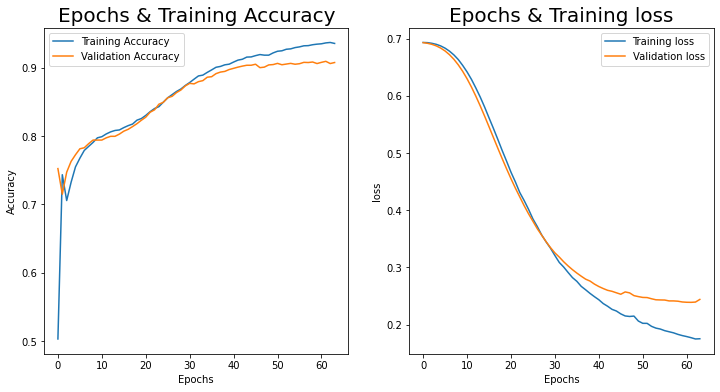

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))

ax[0].plot(history['accuracy'], '-', label = 'Training Accuracy')
ax[0].plot(history['val_accuracy'], '-', label = 'Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Epochs & Training Accuracy', fontsize=20)
ax[0].legend(loc='best')

ax[1].plot(history['loss'], '-', label = 'Training loss')
ax[1].plot(history['val_loss'], '-', label = 'Validation loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('loss')
ax[1].set_title('Epochs & Training loss', fontsize=20)
ax[1].legend(loc='best')

plt.show()

In [11]:
f = open('/kaggle/input/imdb-dataset-of-50k-movie-reviews-clean/data/data/' + dataset + '_vocab.corpus.txt', 'r')
words = f.readlines()
f.close()

vocab_size = len(words)
word_vectors = []
for i in range(vocab_size):
    word = words[i].strip()
    word_vector = word_embeddings[i]
    word_vector_str = ' '.join([str(x) for x in word_vector])
    word_vectors.append(word + ' ' + word_vector_str)

word_embeddings_str = '\n'.join(word_vectors)
f = open(dataset + '_word_vectors.txt', 'w')
f.write(word_embeddings_str)
f.close()

doc_vectors = []
doc_id = 0
for i in range(train_size):
    doc_vector = train_doc_embeddings[i]
    doc_vector_str = ' '.join([str(x) for x in doc_vector])
    doc_vectors.append('doc_' + str(doc_id) + ' ' + doc_vector_str)
    doc_id += 1

for i in range(test_size):
    doc_vector = test_doc_embeddings[i]
    doc_vector_str = ' '.join([str(x) for x in doc_vector])
    doc_vectors.append('doc_' + str(doc_id) + ' ' + doc_vector_str)
    doc_id += 1

doc_embeddings_str = '\n'.join(doc_vectors)
f = open(dataset + '_doc_vectors.txt', 'w')
f.write(doc_embeddings_str)
f.close()